<a href="https://colab.research.google.com/github/radhika281/EVA-4.0/blob/master/Radhika_ASN6_EVA4S6F2_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

#Code 2 L1 regularization
Target:

    1.Add L1 regularization
    2.Results:
        Parameters: 6070
        Best Train Accuracy: 98.26
        Best Test Accuracy: 97.92
    3.Analysis:
        We have started to less over-fitting now. 
        But still needs improvement.
        Number of parameters have significantly reduced

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


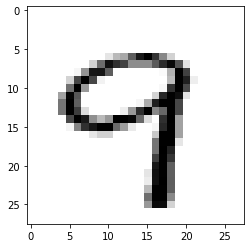

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

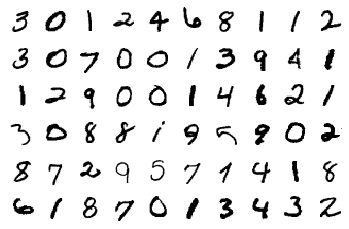

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
 #       self.convblock8 = nn.Sequential(
 #           nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
 #           # nn.ReLU() NEVER!
 #       ) # output_size = 1

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self,x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        #x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  #criterion = nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    loss = F.nll_loss(y_pred, target)
    nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters(): 
        if param.dim() > 1: 
          reg_loss += param.norm(1)

    factor = 0.0005
    loss += factor * reg_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.48109427094459534 Batch_id=468 Accuracy=81.45: 100%|██████████| 469/469 [00:11<00:00, 40.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3561, Accuracy: 9420/10000 (94.20%)

EPOCH: 1


Loss=0.2905671000480652 Batch_id=468 Accuracy=96.33: 100%|██████████| 469/469 [00:11<00:00, 40.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2774, Accuracy: 9336/10000 (93.36%)

EPOCH: 2


Loss=0.2469015121459961 Batch_id=468 Accuracy=96.90: 100%|██████████| 469/469 [00:12<00:00, 38.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2159, Accuracy: 9539/10000 (95.39%)

EPOCH: 3


Loss=0.2398848831653595 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:11<00:00, 41.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1762, Accuracy: 9643/10000 (96.43%)

EPOCH: 4


Loss=0.2555127739906311 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:11<00:00, 39.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2340, Accuracy: 9310/10000 (93.10%)

EPOCH: 5


Loss=0.20239928364753723 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:11<00:00, 41.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2274, Accuracy: 9369/10000 (93.69%)

EPOCH: 6


Loss=0.19300726056098938 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:12<00:00, 37.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1257, Accuracy: 9697/10000 (96.97%)

EPOCH: 7


Loss=0.16518178582191467 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:12<00:00, 36.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1296, Accuracy: 9676/10000 (96.76%)

EPOCH: 8


Loss=0.33269762992858887 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:12<00:00, 38.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1261, Accuracy: 9678/10000 (96.78%)

EPOCH: 9


Loss=0.19694779813289642 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:12<00:00, 38.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1039, Accuracy: 9745/10000 (97.45%)

EPOCH: 10


Loss=0.16003815829753876 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:12<00:00, 37.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1248, Accuracy: 9706/10000 (97.06%)

EPOCH: 11


Loss=0.20535138249397278 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:13<00:00, 34.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1259, Accuracy: 9658/10000 (96.58%)

EPOCH: 12


Loss=0.12058969587087631 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:12<00:00, 36.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1233, Accuracy: 9659/10000 (96.59%)

EPOCH: 13


Loss=0.1385413110256195 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:13<00:00, 35.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1410, Accuracy: 9613/10000 (96.13%)

EPOCH: 14


Loss=0.11239342391490936 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:12<00:00, 38.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0929, Accuracy: 9741/10000 (97.41%)

EPOCH: 15


Loss=0.15282675623893738 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1002, Accuracy: 9748/10000 (97.48%)

EPOCH: 16


Loss=0.14324133098125458 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:12<00:00, 37.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1417, Accuracy: 9604/10000 (96.04%)

EPOCH: 17


Loss=0.1317647099494934 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:12<00:00, 36.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1266, Accuracy: 9654/10000 (96.54%)

EPOCH: 18


Loss=0.11253254115581512 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:12<00:00, 38.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0865, Accuracy: 9782/10000 (97.82%)

EPOCH: 19


Loss=0.11980248987674713 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1087, Accuracy: 9723/10000 (97.23%)

EPOCH: 20


Loss=0.19274185597896576 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:11<00:00, 40.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0935, Accuracy: 9769/10000 (97.69%)

EPOCH: 21


Loss=0.11156962066888809 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:12<00:00, 38.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0737, Accuracy: 9823/10000 (98.23%)

EPOCH: 22


Loss=0.11195183545351028 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:12<00:00, 37.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0738, Accuracy: 9848/10000 (98.48%)

EPOCH: 23


Loss=0.18446844816207886 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:12<00:00, 37.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0735, Accuracy: 9817/10000 (98.17%)

EPOCH: 24


Loss=0.11087699979543686 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:12<00:00, 38.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1076, Accuracy: 9693/10000 (96.93%)

EPOCH: 25


Loss=0.13716644048690796 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:12<00:00, 38.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0995, Accuracy: 9757/10000 (97.57%)

EPOCH: 26


Loss=0.12570486962795258 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:12<00:00, 38.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0844, Accuracy: 9776/10000 (97.76%)

EPOCH: 27


Loss=0.2207299768924713 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:12<00:00, 38.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0662, Accuracy: 9837/10000 (98.37%)

EPOCH: 28


Loss=0.10640237480401993 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:12<00:00, 37.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1360, Accuracy: 9582/10000 (95.82%)

EPOCH: 29


Loss=0.15660205483436584 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:11<00:00, 39.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0664, Accuracy: 9815/10000 (98.15%)

EPOCH: 30


Loss=0.23376035690307617 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:12<00:00, 37.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0840, Accuracy: 9777/10000 (97.77%)

EPOCH: 31


Loss=0.11932496726512909 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:11<00:00, 40.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0825, Accuracy: 9779/10000 (97.79%)

EPOCH: 32


Loss=0.10076592117547989 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:12<00:00, 36.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0730, Accuracy: 9806/10000 (98.06%)

EPOCH: 33


Loss=0.1240663230419159 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:11<00:00, 40.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0816, Accuracy: 9778/10000 (97.78%)

EPOCH: 34


Loss=0.16503652930259705 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:12<00:00, 38.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0618, Accuracy: 9835/10000 (98.35%)

EPOCH: 35


Loss=0.11246614158153534 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:11<00:00, 40.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0857, Accuracy: 9748/10000 (97.48%)

EPOCH: 36


Loss=0.13239678740501404 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:12<00:00, 37.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0807, Accuracy: 9766/10000 (97.66%)

EPOCH: 37


Loss=0.20487602055072784 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:11<00:00, 39.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1019, Accuracy: 9701/10000 (97.01%)

EPOCH: 38


Loss=0.18749278783798218 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:11<00:00, 44.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0703, Accuracy: 9841/10000 (98.41%)

EPOCH: 39


Loss=0.09743770211935043 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:12<00:00, 44.49it/s]



Test set: Average loss: 0.0791, Accuracy: 9792/10000 (97.92%)



Text(0.5, 1.0, 'Test Accuracy')

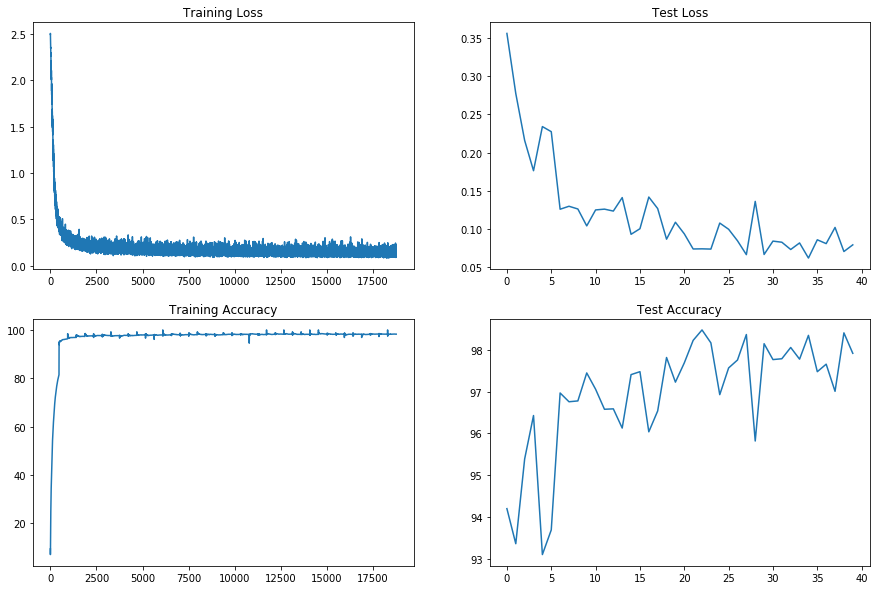

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")